In [1]:
import numpy as np
import matplotlib.pyplot as plt
import audio2numpy as a2n
import scipy
import scipy.io as sio
import scipy.fftpack

import warnings
warnings.filterwarnings('ignore')

In [2]:
fr = 16384
SAMPLE_RATE = fr * 5 + 1

In [23]:
def MorleWewlet(t, freq = 2, sigma=0.1):
    return np.exp((-t**2)/(sigma**2)) * np.exp(1j * 2 * np.pi * freq * t)

def MexicanHat(t, freq=1, sigma=0.1):
    return (1 - t**2) * np.exp(-t**2 / (2 * sigma**2)) * np.cos(2 * np.pi * freq * t)

def Haar(t, freq=1):
    t_scaled = t * freq
    result = np.zeros_like(t_scaled)

    result[(0 <= t_scaled) & (t_scaled < 0.5)] = 1
    result[(0.5 <= t_scaled) & (t_scaled < 1)] = -1

    return result

    
def create_wavelet_signal(wavelet_function, t_start, t_end, samples, wavelet_params={}):
    time = np.linspace(t_start, t_end, samples)
    signal = np.zeros(len(time), dtype=complex)
    for i, t in enumerate(time):
        signal[i] = wavelet_function(t, **wavelet_params)
    return time, signal

def apply_wavelet(signal, wavelet):
    result = np.convolve(signal, wavelet, mode='same')
    return result


def rec_imp(t):
    t_r = np.floor(t)
    if t_r % 2 == 0:
        return 2
    else:
        return -2

def calc_signal(s_func, *args, t_start = 0, t_end = None, samples = None):
    if t_end is None:
        t_end = 2
    if samples is None:
        samples = 1000

    time_series = np.linspace(t_start, t_end, samples)
    signal_vals = np.array([s_func(*args, t) for t in time_series])

    return signal_vals, time_series

def get_positive_spectrum(spectrum):
    positive_spectrum = np.abs(spectrum[:len(spectrum) // 2])
    positive_frequencies = np.fft.fftfreq(len(spectrum), 1 / SAMPLE_RATE)[:len(spectrum) // 2]
    return positive_frequencies, positive_spectrum



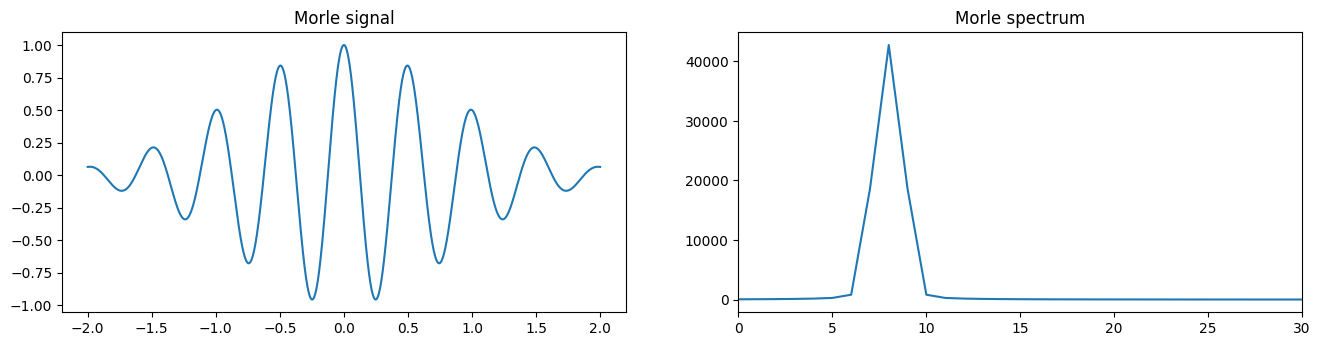

In [4]:
welwetMorle_timeseries, wewletMorle_signal = create_wavelet_signal(MorleWewlet, wavelet_params={"sigma":1.2}, t_start=-2, t_end=2, samples=SAMPLE_RATE)
wewletMorle_spectrum = np.fft.fft(wewletMorle_signal)

fig = plt.figure(figsize=(16,8))

plt.subplot(221)
plt.title("Morle signal")
plt.plot(welwetMorle_timeseries, wewletMorle_signal)
plt.subplot(222)
plt.title("Morle spectrum")
plt.plot(*get_positive_spectrum(wewletMorle_spectrum))
plt.xlim([0, 30])

plt.show()

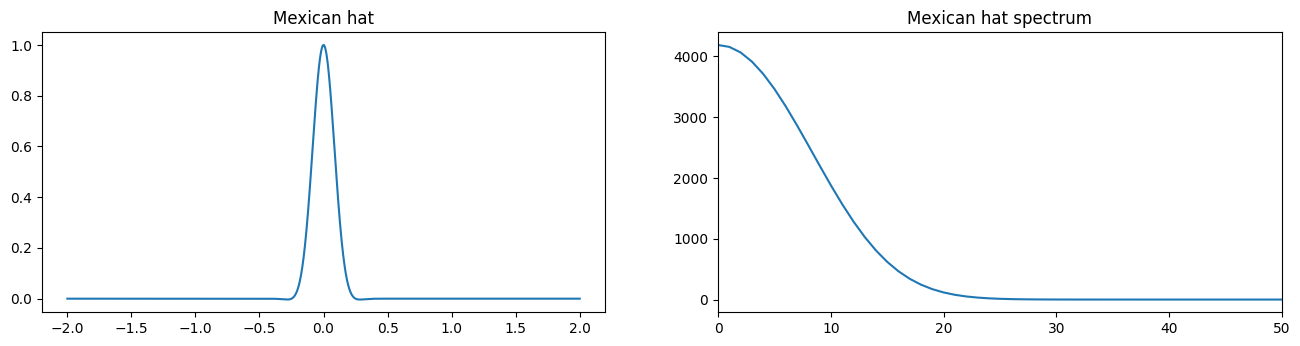

In [15]:
MexicanHat_timeseries, MexicanHat_signal = create_wavelet_signal(MexicanHat, t_start=-2, t_end=2, samples=SAMPLE_RATE)
MexicanHat_spectrum = np.fft.fft(MexicanHat_signal)

fig = plt.figure(figsize=(16,8))

plt.subplot(221)
plt.title("Mexican hat")
plt.plot(MexicanHat_timeseries, MexicanHat_signal)
plt.subplot(222)
plt.title("Mexican hat spectrum")
plt.plot(*get_positive_spectrum(MexicanHat_spectrum))
plt.xlim([0, 50])

plt.show()

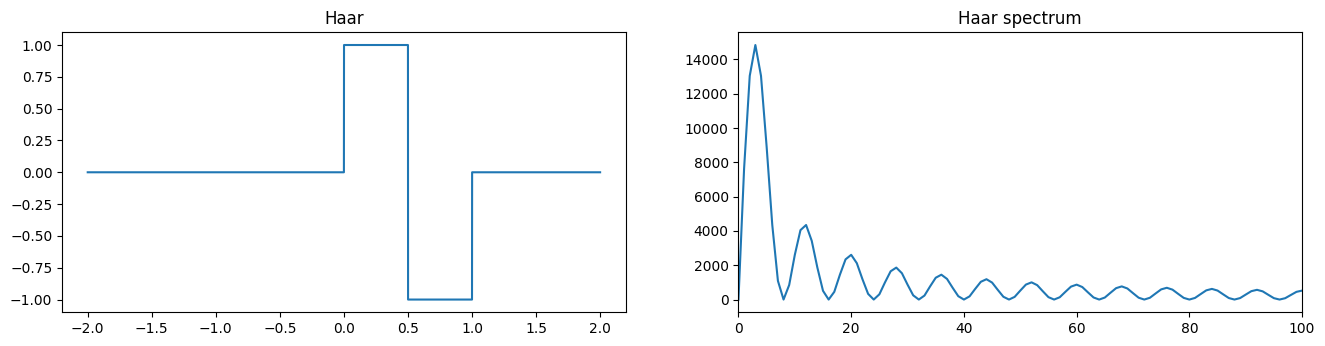

In [24]:
Haar_timeseries, Haar_signal = create_wavelet_signal(Haar, t_start=-2, t_end=2, samples=SAMPLE_RATE)
HaarW_spectrum = np.fft.fft(Haar_signal)

fig = plt.figure(figsize=(16,8))

plt.subplot(221)
plt.title("Haar")
plt.plot(Haar_timeseries, Haar_signal)
plt.subplot(222)
plt.title("Haar spectrum")
plt.plot(*get_positive_spectrum(HaarW_spectrum))
plt.xlim([0, 100])

plt.show()

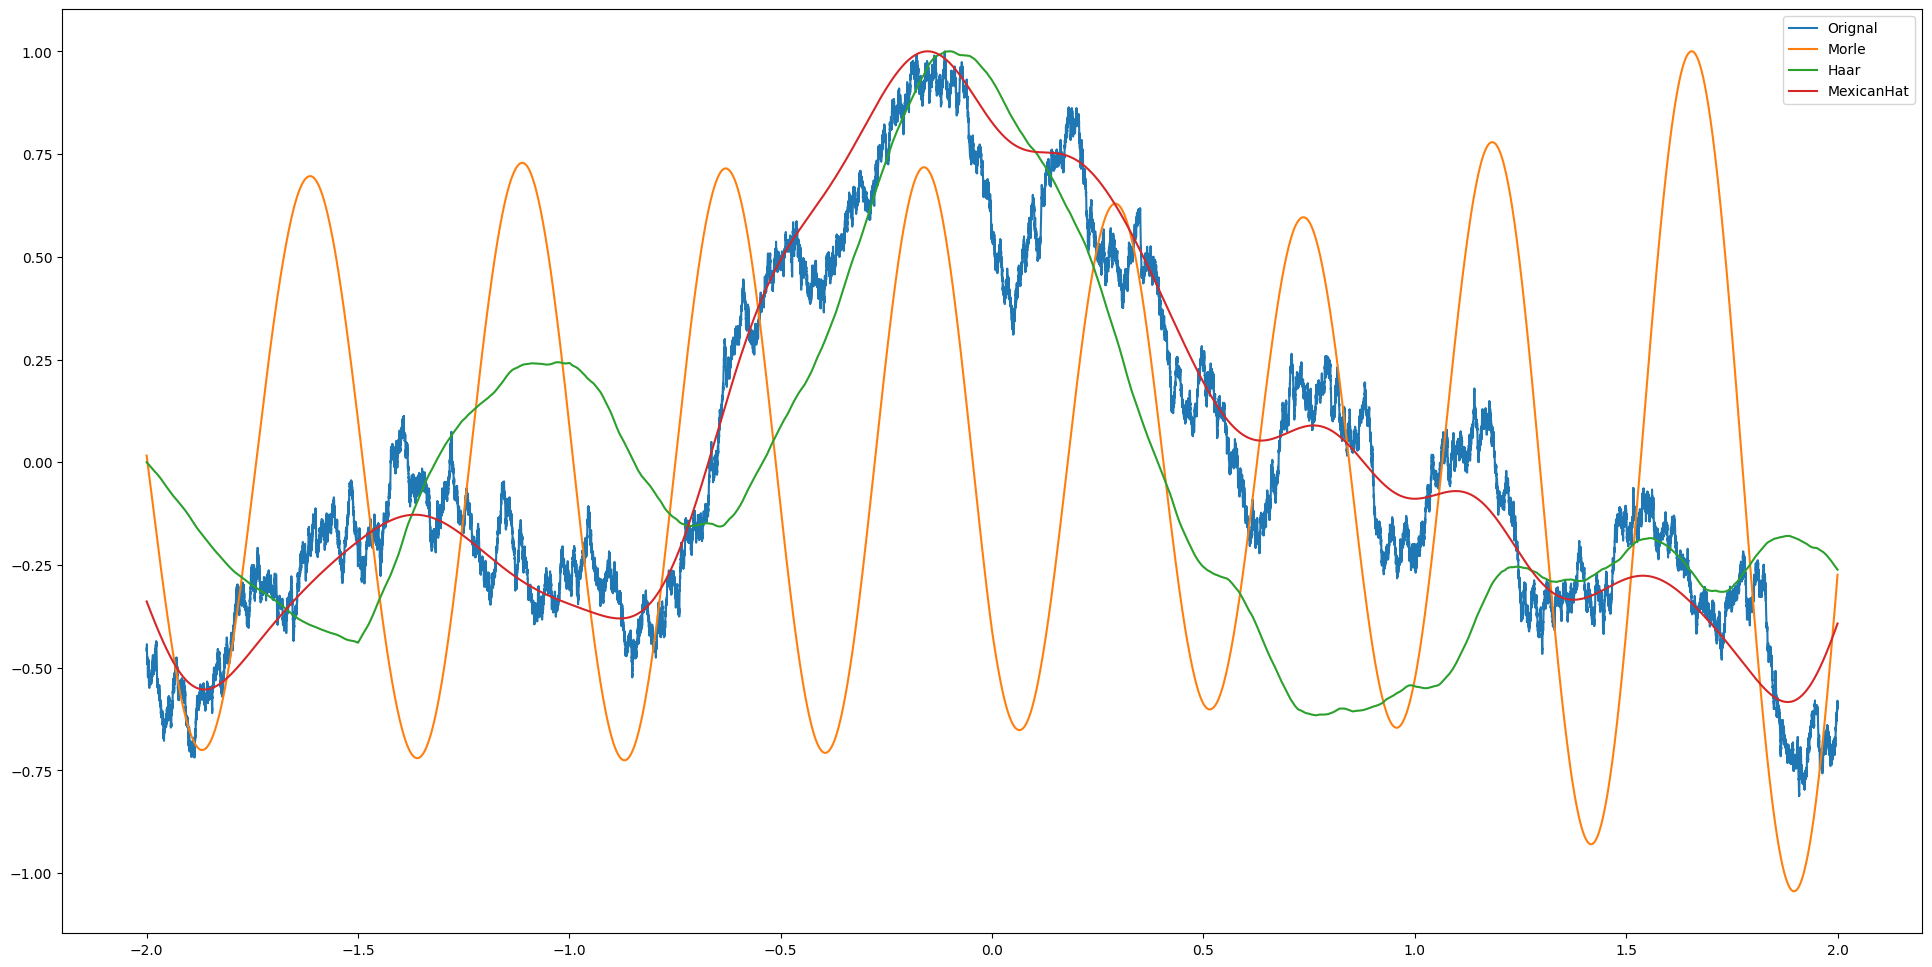

In [7]:
def convole_by_welet(signal_func, wewlet_kernel, normalize=False):
    conved = np.convolve(signal_func, wewlet_kernel, 'same')
    if normalize: conved /= np.max(conved)
    return conved

np.random.seed(422)
signal_ = scipy.signal.detrend(np.cumsum(np.random.randn(SAMPLE_RATE)))

signal_morle_conved   = convole_by_welet(signal_, wewletMorle_signal, True)
signal_haar_conved    = convole_by_welet(signal_, Haar_signal, True)
signal_mexican_conved = convole_by_welet(signal_, MexicanHat_signal, True)


fig = plt.figure(figsize=(24,12))

plt.plot(welwetMorle_timeseries, signal_/np.max(signal_), label='Orignal')
plt.plot(welwetMorle_timeseries, signal_morle_conved, label='Morle')
plt.plot(welwetMorle_timeseries, signal_haar_conved, label='Haar')
plt.plot(welwetMorle_timeseries, signal_mexican_conved, label="MexicanHat")
plt.legend()
plt.show()

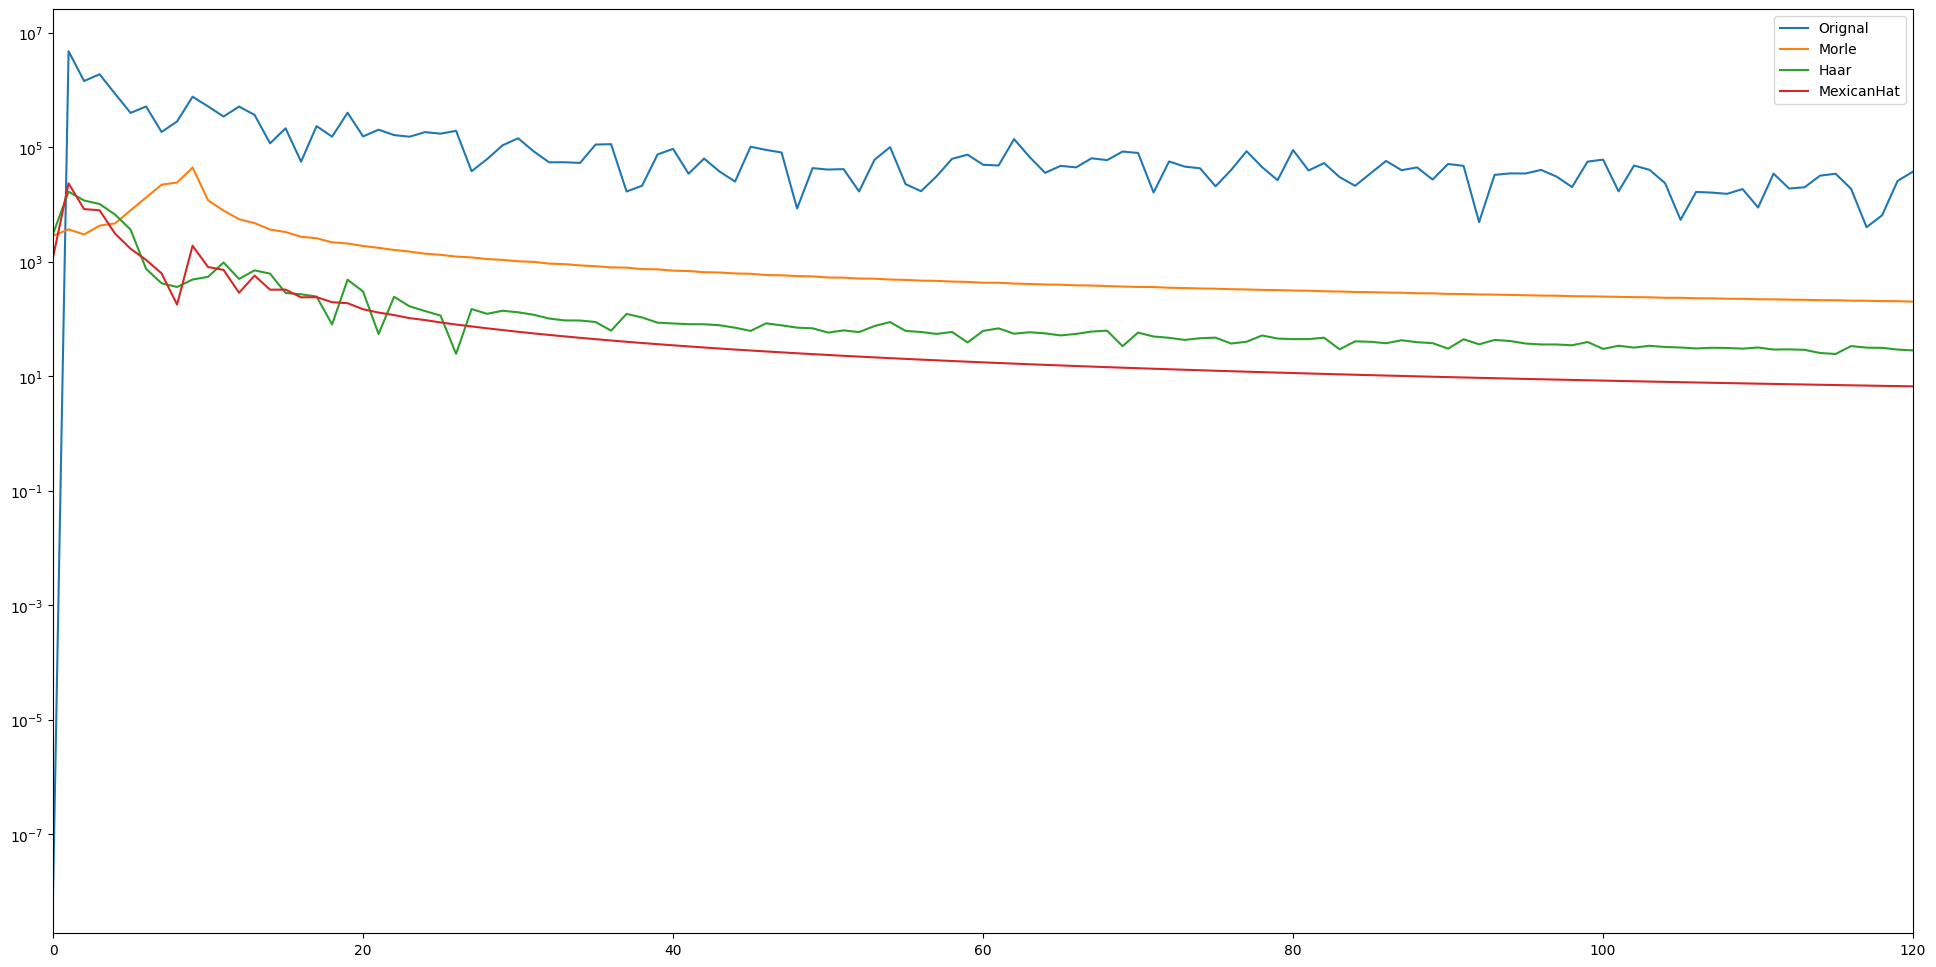

In [8]:
fig = plt.figure(figsize=(24,12))

signal_spec = np.fft.fft(signal_)
signal_morle_conved_spec   = np.fft.fft(signal_morle_conved)
signal_haar_conved_spec    = np.fft.fft(signal_haar_conved)
signal_mexican_conved_spec = np.fft.fft(signal_mexican_conved)


plt.plot(*get_positive_spectrum(signal_spec), label='Orignal')
plt.plot(*get_positive_spectrum(signal_morle_conved_spec), label='Morle')
plt.plot(*get_positive_spectrum(signal_haar_conved_spec), label='Haar')
plt.plot(*get_positive_spectrum(signal_mexican_conved_spec), label="MexicanHat")
plt.xlim([0, 120])
plt.yscale('log')
plt.legend()
plt.show()

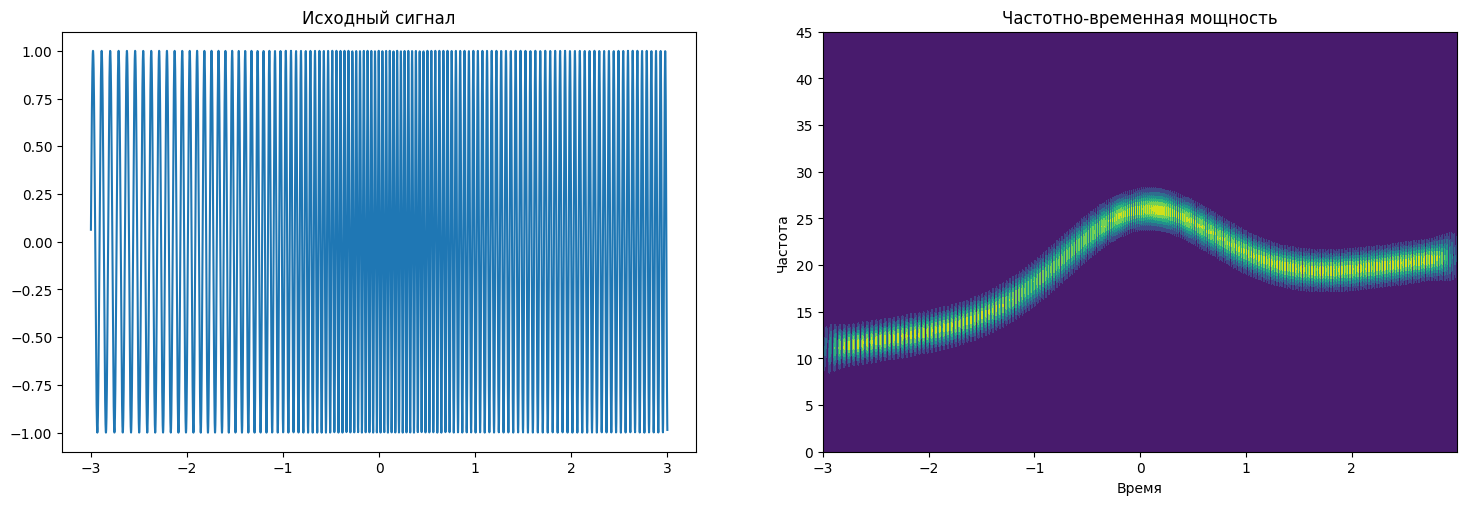

In [54]:
def create_signal(time, samples_rate=1000):
    points = len(time)
    
    freq_mod = np.exp(-time**2) * 10 + 10
    freq_mod = freq_mod + np.linspace(0, 10, points)
    
    signal = np.sin(2 * np.pi * (time + np.cumsum(freq_mod) / samples_rate))
    
    return signal

def create_wavelets(wavelet_function, time, Freq1=50, Freq2_min=0, Freq2_max = 50, wavelet_params={}):
    """
    Создает вейвлеты на основе заданной функции вейвлета для различных частот.

    Args:
        wavelet_function (function): Функция вейвлета, зависящая от времени и частоты.
        time (numpy.ndarray): Массив времени, используемый для создания вейвлетов.
        Freq1 (int): Количество частот (вейвлетов) для создания.
        Freq2_min (float): Минимальная частота в диапазоне частот вейвлетов.
        Freq2_max (float): Максимальная частота в диапазоне частот вейвлетов.
        wavelet_params (dict): Параметры, передаваемые в функцию вейвлета.
    Returns:
        Freq2 (numpy.ndarray): Массив частот вейвлетов.
        Ws (numpy.ndarray): Массив вейвлетов, где каждая строка представляет собой вейвлет
            для соответствующей частоты из Freq2.
    """
    Freq2 = np.linspace(Freq2_min, Freq2_max, Freq1)
    Ws = np.zeros((Freq1, len(time)), dtype=complex)

    for wi in range(0, Freq1):
        wavelet = wavelet_function


    Freq2 = np.linspace(Freq2_min, Freq2_max, Freq1)
    Ws = np.zeros((Freq1, len(time)), dtype=complex)
    
    for wi in range(0, Freq1):
        wavelet = wavelet_function(time, Freq2[wi], **wavelet_params)
        Ws[wi, :] = wavelet
        
    return Freq2, Ws

def compute_time_frequency(time, signal, Freq2, Ws, wewlet_time=None):
    """
    Вычисляет частотно-временную мощность с использованием вейвлетов.

    Args:
        time (numpy.ndarray): Массив времени.
        signal (numpy.ndarray): Сигнал, для которого вычисляется частотно-временная мощность.
        Freq2 (numpy.ndarray): Массив частот вейвлетов.
        Ws (numpy.ndarray): Массив вейвлетов.
        wewlet_time (numpy.ndarray, optional): Массив времени вейвлета, если задан. По умолчанию None.

    Returns:
        tf (numpy.ndarray): Матрица частотно-временной мощности, где каждая строка представляет мощность
            для соответствующей частоты из Freq2.
    """
    if wewlet_time is None:
        conv = len(time) * 2 - 1
        half = len(time) // 2
    else:
        conv = len(time) + len(wewlet_time) - 1
        half = len(wewlet_time) // 2
    
    sigX = scipy.fftpack.fft(signal, conv)
    tf = np.zeros((len(Freq2), len(time)))

    for fi in range(len(Freq2)):
        waveX = scipy.fftpack.fft(Ws[fi, :], conv)
        waveX = waveX / np.max(waveX)
        conv_res = scipy.fftpack.ifft(waveX * sigX)
        conv_res = conv_res[half - 1: -half][:time.shape[0]]
        tf[fi, :] = np.abs(conv_res)**2

    return tf


samples_rate = 1000
time_series = np.arange(-3, 3, 1/samples_rate)
signal = create_signal(time_series, samples_rate)
# signal = np.cos(time_series * np.pi * 20 * 2) 
Freq2, Ws = create_wavelets(MexicanHat, time_series, Freq1=70, Freq2_max=45, wavelet_params={"sigma":0.1})
# Freq2, Ws = create_wavelets(MorleWewlet, time_series, Freq1=70, Freq2_max=35, wavelet_params={"sigma":0.07})
# Freq2, Ws = create_wavelets(Haar, time_series, Freq1=20, Freq2_max=150)
tf = compute_time_frequency(time_series, signal, Freq2, Ws)

fig = plt.figure(figsize=(18, 12))
plt.subplot(221)
plt.title("Исходный сигнал")
plt.plot(time_series, signal)


plt.subplot(222)
plt.contourf(time_series, Freq2, tf)
plt.xlabel('Время')
plt.ylabel('Частота')
plt.title('Частотно-временная мощность')

plt.show()


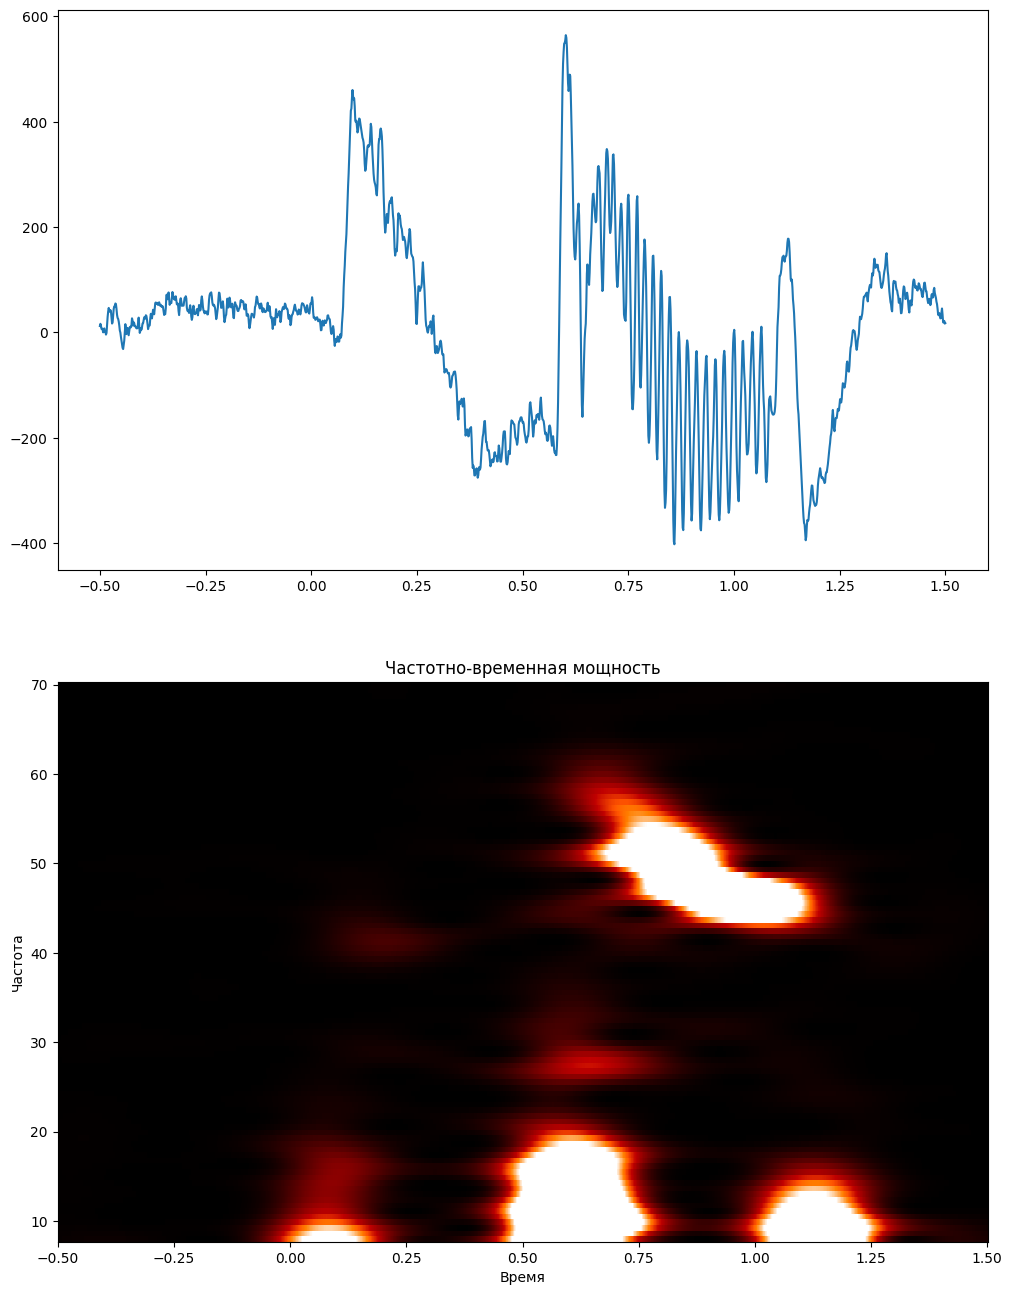

In [16]:
braindata = sio.loadmat('Lab6_Data.mat')
time_vec = braindata['timevec'][0]
s_rate = braindata['srate'][0]
data = braindata['data'][0]

wewlet_time_series = np.arange(-2, 2, 1 / s_rate)
Freq2, Ws = create_wavelets(MorleWewlet, wewlet_time_series, Freq1=100,  Freq2_min=8, Freq2_max=70, wavelet_params={"sigma":0.15})
tf = compute_time_frequency(time_vec, data, Freq2, Ws, wewlet_time_series)


fig = plt.figure(figsize=(12,16))
plt.subplot(211)
plt.plot(time_vec, data)

plt.subplot(212)
plt.pcolormesh(time_vec, Freq2, tf, vmin=0, vmax=1e3, cmap = 'gist_heat')
plt.xlabel('Время')
plt.ylabel('Частота')
plt.title('Частотно-временная мощность')

plt.show()

In [32]:
data, s_rate = a2n.audio_from_file("lab_6_tiny.mp3")
time_series = np.linspace(0, 1, num=len(data))

print(s_rate)

11025


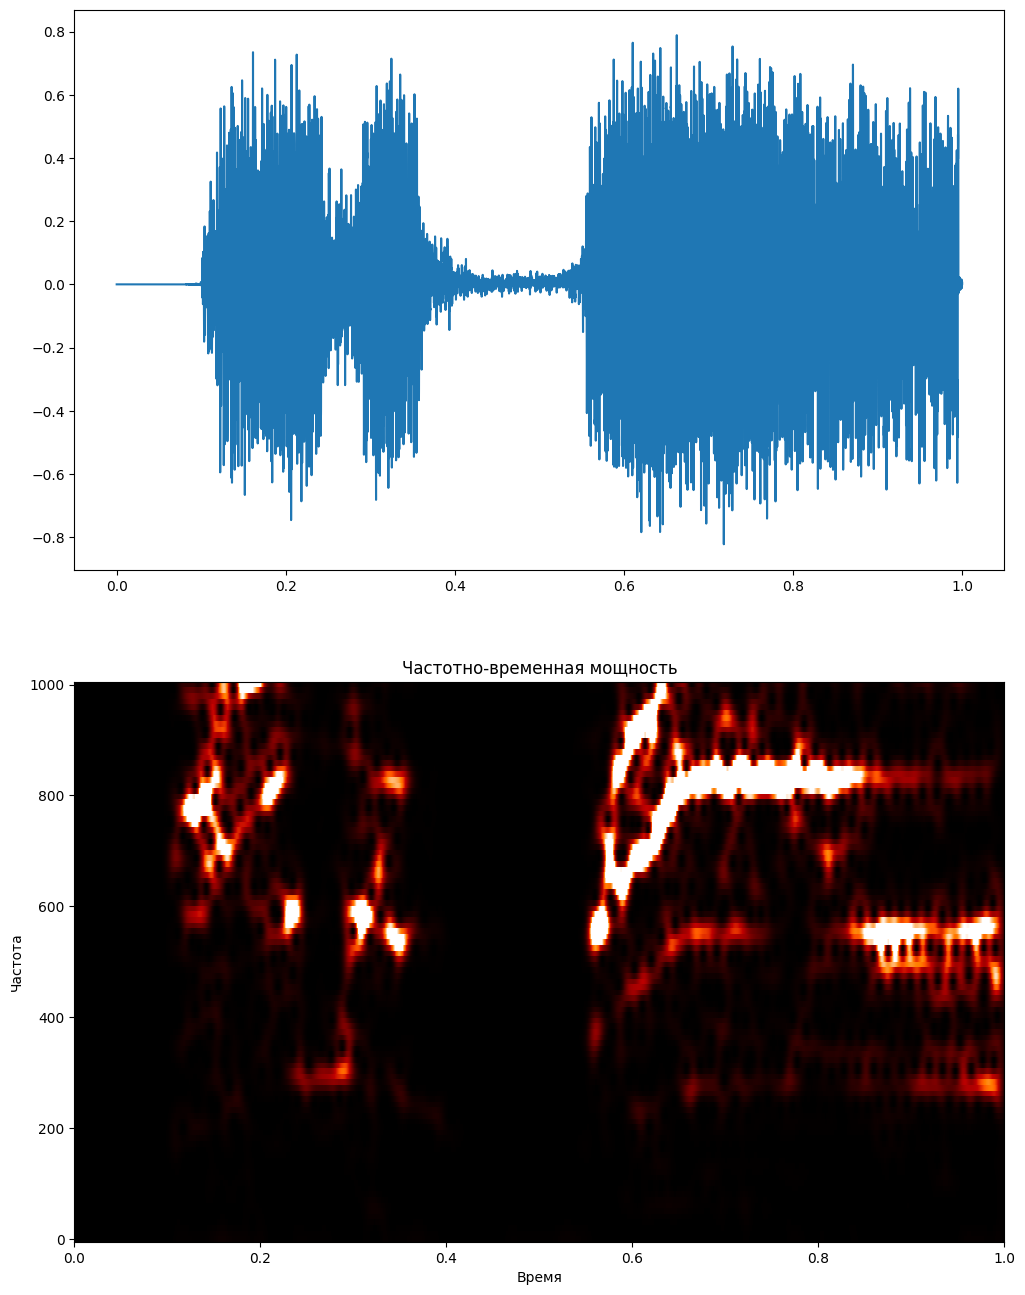

In [36]:
wewlet_time_series = np.arange(-2, 2, 1 / s_rate)
Freq2, Ws = create_wavelets(MorleWewlet, wewlet_time_series, Freq1=100,  Freq2_min=0, Freq2_max=1000, wavelet_params={"sigma":0.01})
tf = compute_time_frequency(time_series, data, Freq2, Ws, wewlet_time_series)


fig = plt.figure(figsize=(12,16))
plt.subplot(211)
plt.plot(time_series, data)

plt.subplot(212)
plt.pcolormesh(time_series, Freq2, tf, vmin=0, vmax=0.0075, cmap = 'gist_heat')
plt.xlabel('Время')
plt.ylabel('Частота')
plt.title('Частотно-временная мощность')

plt.show()